In [17]:
import os

In [5]:
#for creating the label text file

#closed
closed_path = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset\closed"
f_open_path = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset\fully_open"
s_open_path = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset\semi_open"
tilt_path   = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset\tilted"
paths = [closed_path,f_open_path,s_open_path,tilt_path]
label_folder_path = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset"
label_file_name = 'labels.txt'
label_file_path = label_folder_path + '\\' + label_file_name

for path in paths:
    if path == closed_path:
        add_on = 'closed'
    elif path == f_open_path:
        add_on = 'fully_open'
    elif path == s_open_path:
        add_on = 'semi_open'
    elif path == tilt_path:
        add_on = 'tilted'
    for img in os.listdir(path):
        with open(label_file_path, 'a') as file:
            file.write(img+','+add_on+'\n')
print('Done')
        

Done


In [6]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn as nn
print(torch.cuda.is_available())
device = torch.device('cuda')
print(device)
dataset_path = r"C:\Users\gokul\Desktop\CSIS_SS23\vgg_dataset\dataset"

True
cuda


In [8]:
#preprocessing the dataset
#Data Augmentation techniques
mean = (0.5,0.5,0.5)
std = (0.5,0.5,0.5)
sharpness_factor = 2
transforms = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.RandomAdjustSharpness(sharpness_factor),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(brightness=0.23,
                                                       contrast=0.39,
                                                       saturation=0.22,
                                                       hue=0.1),
                                transforms.GaussianBlur(kernel_size=3),
                                transforms.RandomPerspective(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
])

In [9]:
#Loading the dataset
dataset = datasets.ImageFolder(dataset_path, transform=transforms)

# with open(os.path.join(dataset_path,'labels.txt'), 'r') as file:
#     label_data = file.readlines()
#     labels = {line.split()[0]: line.split()[1].rstrip() for line in label_data}
class_nos = {}

for _,class_index in dataset:
    name = dataset.classes[class_index]
    if name not in class_nos:
        class_nos[name] = 0
    class_nos[name] += 1
print(class_nos)

{'closed': 145, 'fully_open': 158, 'semi_open': 154, 'tilted': 159}


In [8]:
#preparing training and val sets
size_train = int(len(dataset)*0.8)
size_val = int(len(dataset) - size_train)
train_ds, val_ds = random_split(dataset, [size_train,size_val])

train_data = DataLoader(train_ds,batch_size=16,shuffle=True)
val_data = DataLoader(val_ds, batch_size=8, shuffle=False)

In [9]:
#loding pre-trained VGG

model_vgg = models.vgg16(pretrained=True)

C:\Users\gokul\.conda\envs\new_env_csis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gokul\.conda\envs\new_env_csis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
for parameters in model_vgg.parameters():
    parameters.requires_grad = False

model_vgg.classifier[6] = nn.Linear(4096, len(dataset.classes))

epochs = 50
learning_rate = 0.001
momentum = 0.8
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_vgg.classifier.parameters(),
                      lr = learning_rate,
                      momentum=momentum)
model_vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
#Training
for epoch in range(epochs):
    train_loss = 0
    train_crct = 0
    
    model_vgg.train()
    for imgs,lbls in train_data:
        imgs,lbls = imgs.to(device),lbls.to(device)
        optimizer.zero_grad()
        output = model_vgg(imgs)
        _,pred = torch.max(output,1)
        
        loss = loss_func(output,lbls)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_crct += torch.sum(pred == lbls).item()
    train_loss /= len(train_data.dataset)
    train_accuracy = train_crct / len(train_data.dataset)
    
    print(f'epochs {epoch+1}/{epochs}:')
    print(f'training_loss : {train_loss:.3f}, Training_Accuracy: {train_accuracy:.3f}')
print('Training Completed')

epochs 1/50:
training_loss : 0.086, Training_Accuracy: 0.335
epochs 2/50:
training_loss : 0.075, Training_Accuracy: 0.459
epochs 3/50:
training_loss : 0.072, Training_Accuracy: 0.480
epochs 4/50:
training_loss : 0.067, Training_Accuracy: 0.543
epochs 5/50:
training_loss : 0.069, Training_Accuracy: 0.506
epochs 6/50:
training_loss : 0.063, Training_Accuracy: 0.543
epochs 7/50:
training_loss : 0.063, Training_Accuracy: 0.608
epochs 8/50:
training_loss : 0.064, Training_Accuracy: 0.569
epochs 9/50:
training_loss : 0.061, Training_Accuracy: 0.579
epochs 10/50:
training_loss : 0.061, Training_Accuracy: 0.589
epochs 11/50:
training_loss : 0.060, Training_Accuracy: 0.581
epochs 12/50:
training_loss : 0.060, Training_Accuracy: 0.608
epochs 13/50:
training_loss : 0.055, Training_Accuracy: 0.644
epochs 14/50:
training_loss : 0.059, Training_Accuracy: 0.602
epochs 15/50:
training_loss : 0.057, Training_Accuracy: 0.628
epochs 16/50:
training_loss : 0.059, Training_Accuracy: 0.634
epochs 17/50:
tra

In [12]:
#Validation
model_vgg.eval()
val_loss = 0
val_crct = 0

with torch.no_grad():
    for imgs, lbls in val_data:
        imgs,lbls = imgs.to(device), lbls.to(device)
        
        output = model_vgg(imgs)
        _,pred = torch.max(output,1)
        
        loss = loss_func(output,lbls)
        
        val_loss += loss.item()
        val_crct += torch.sum(pred == lbls).item()
        
val_loss /= len(val_data.dataset)
val_accuracy = val_crct / len(val_data.dataset)
print(f'Validation_loss : {val_loss:.3f}, Validation_accuracy: {val_accuracy:.3f}')

Validation_loss : 0.098, Validation_accuracy: 0.726


In [13]:
torch.save(model_vgg.state_dict(),'run_2_vgg.pt')

In [15]:
from torchvision.transforms import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

C:\Users\gokul\.conda\envs\new_env_csis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gokul\.conda\envs\new_env_csis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


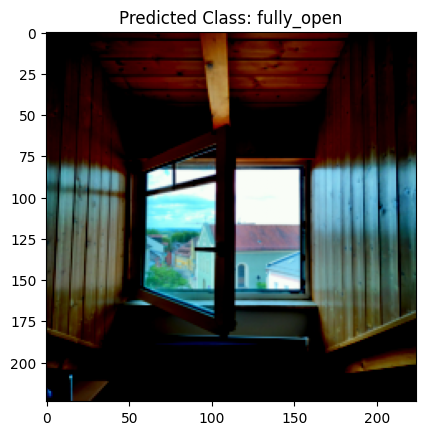

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


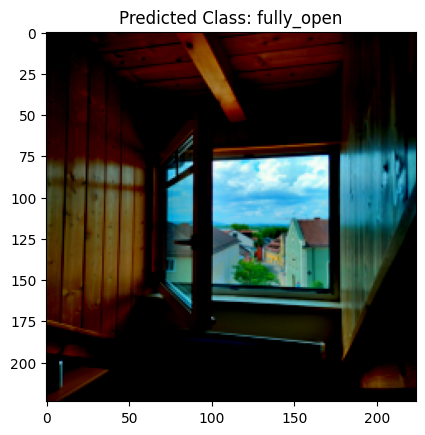

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


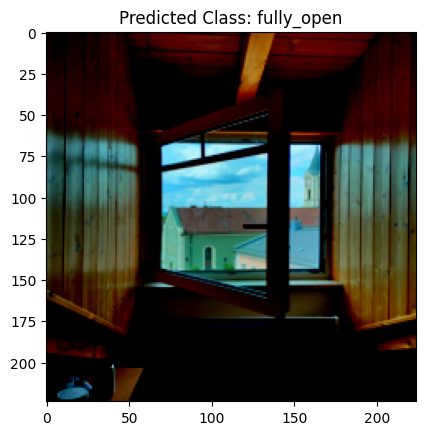

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


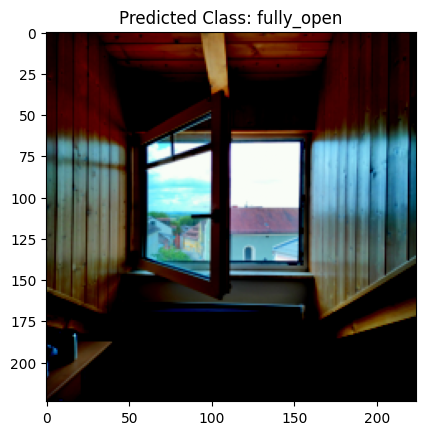

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


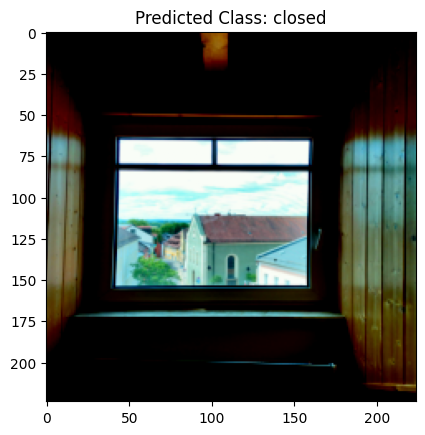

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


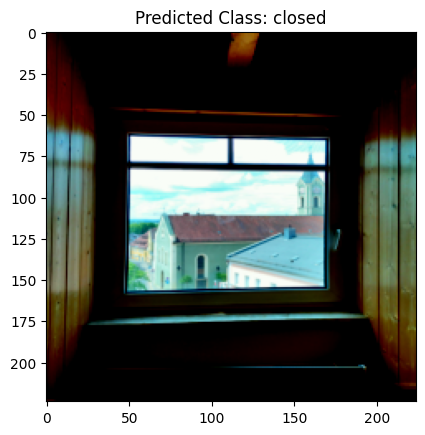

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


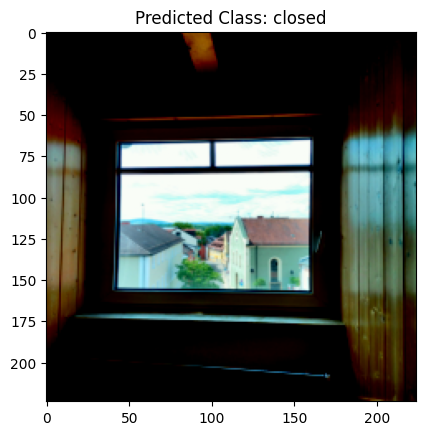

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


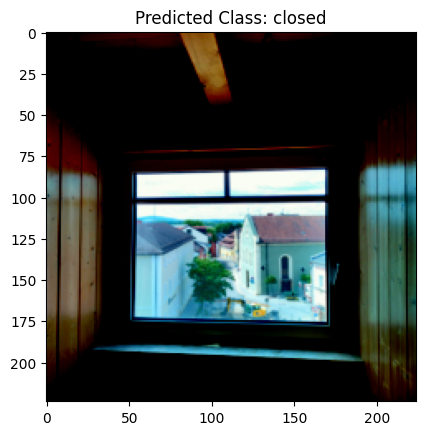

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


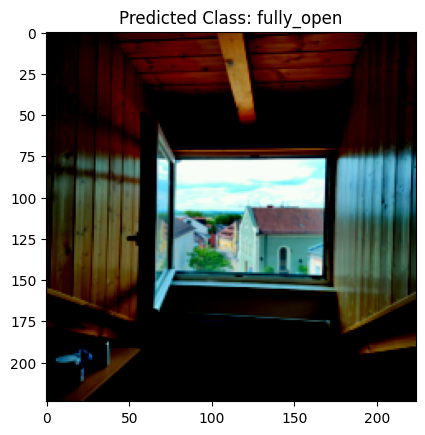

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


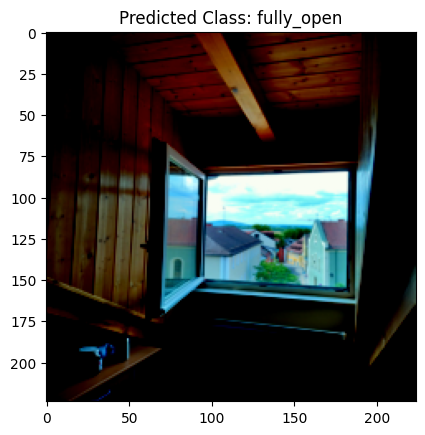

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


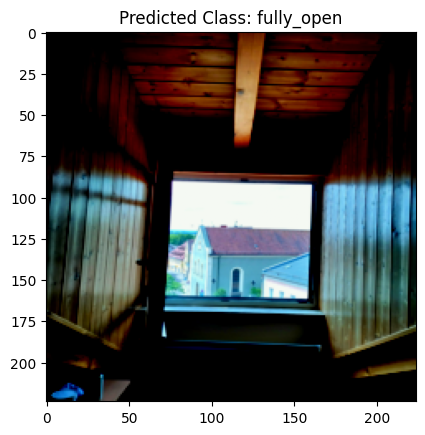

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


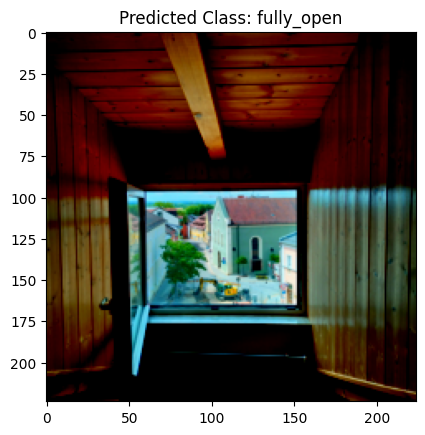

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


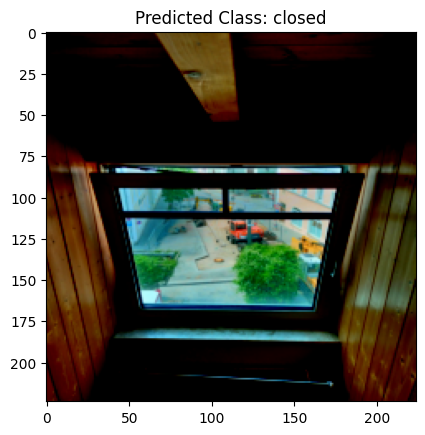

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


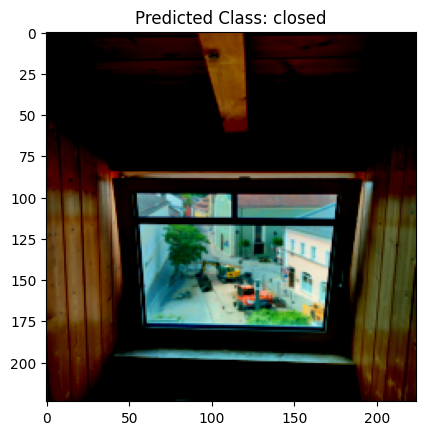

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


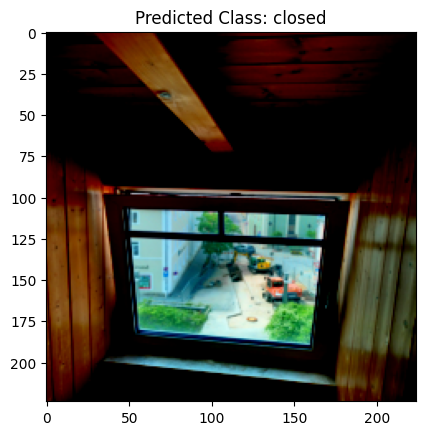

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


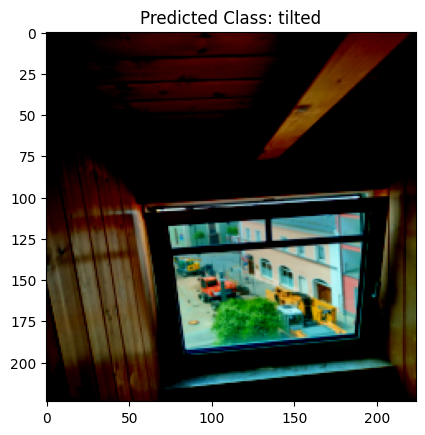

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


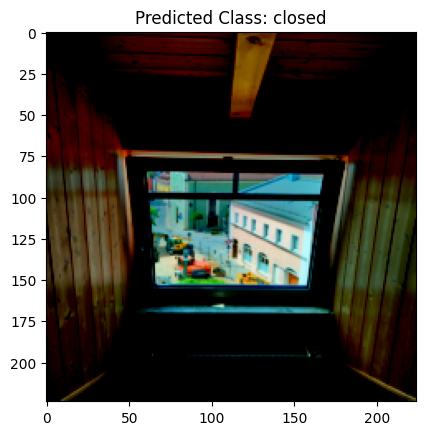

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


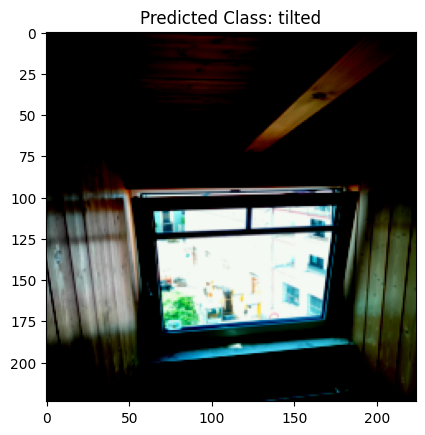

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


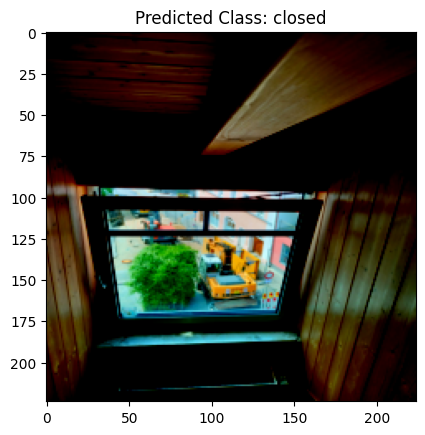

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


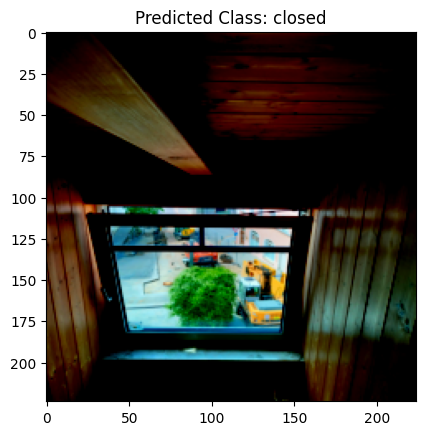

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


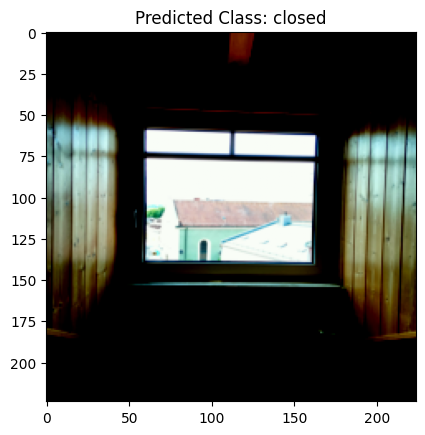

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


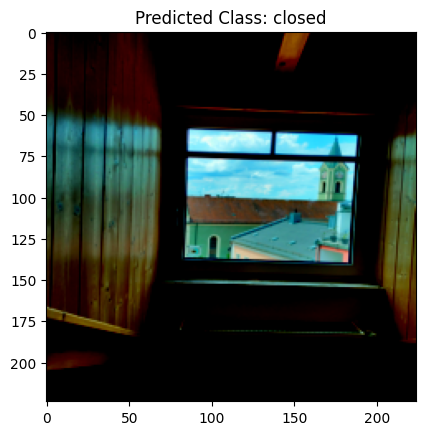

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


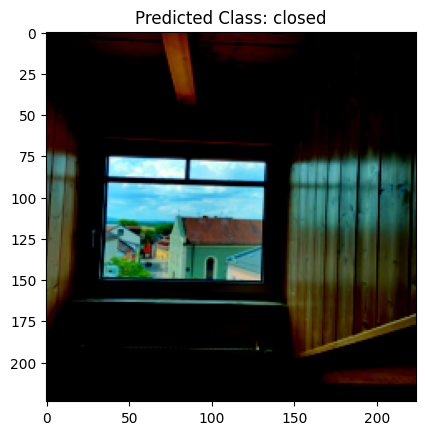

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


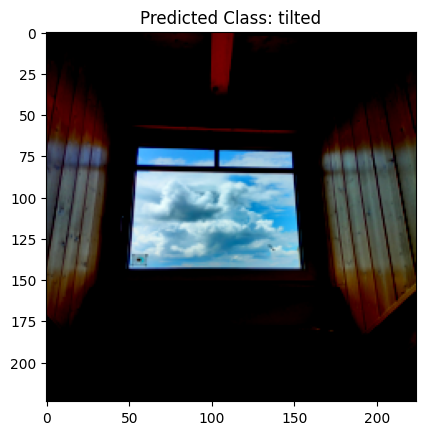

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


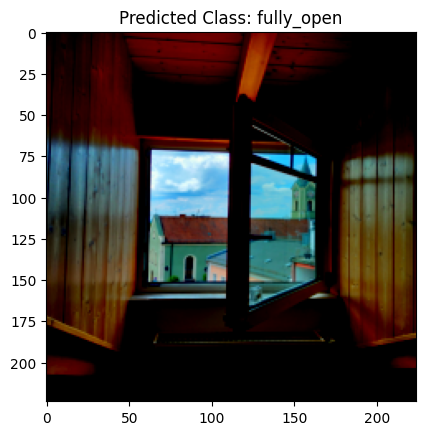

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


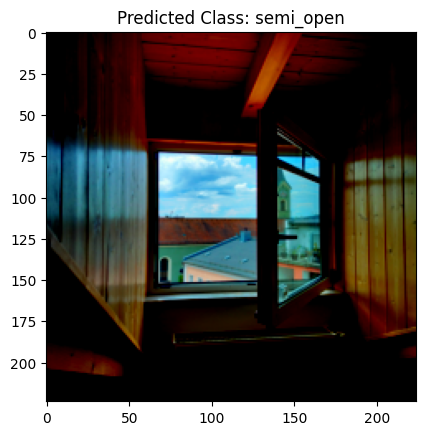

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


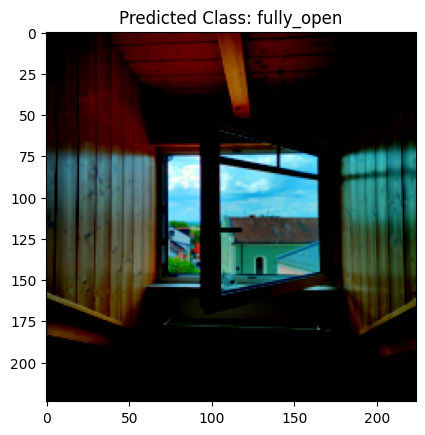

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


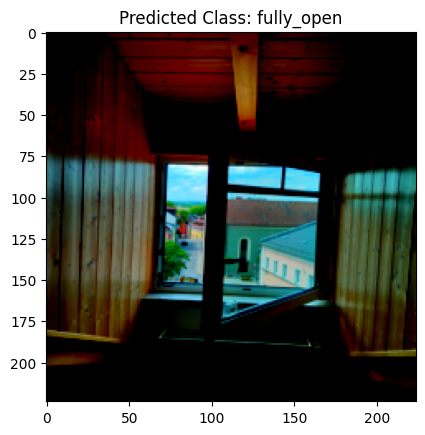

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


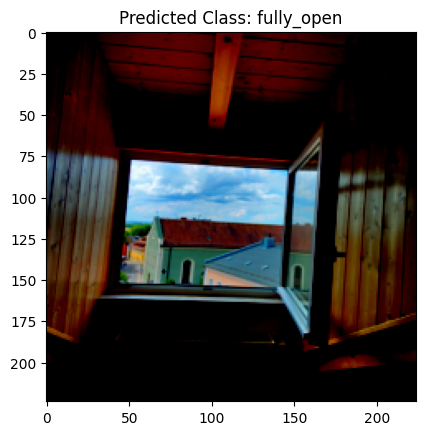

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


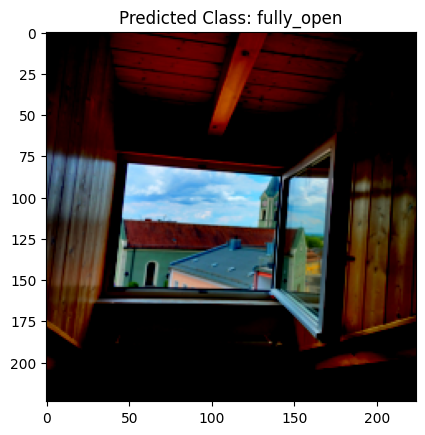

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


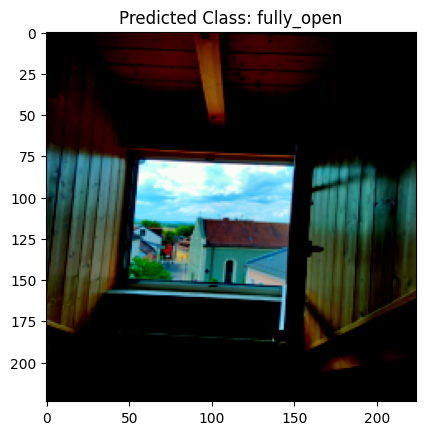

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


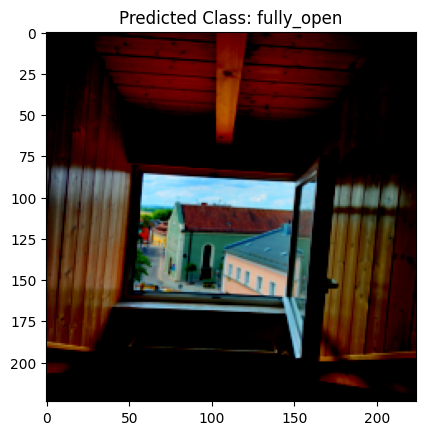

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


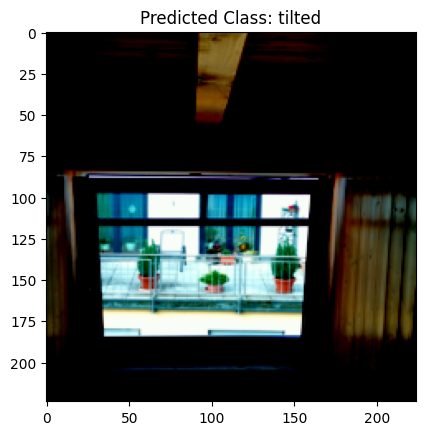

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


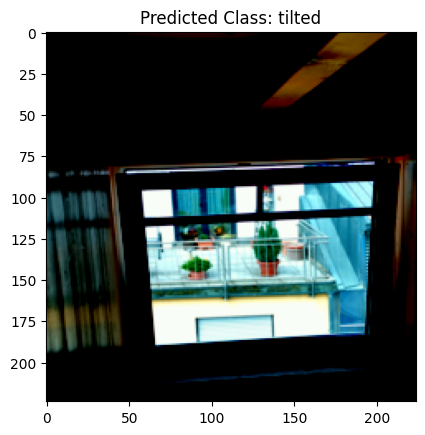

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


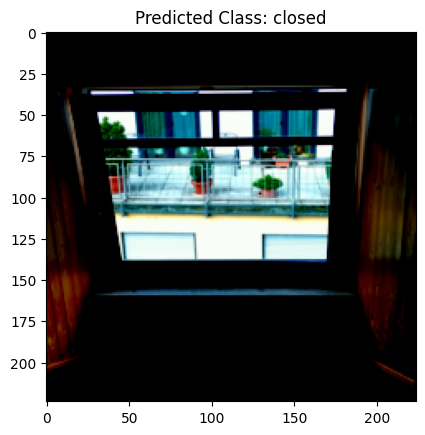

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


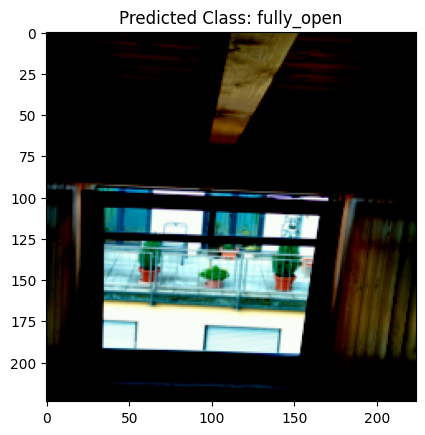

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


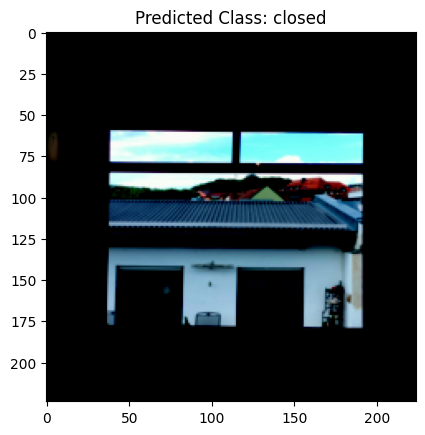

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


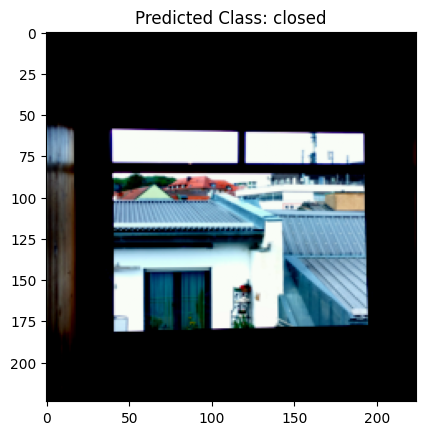

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


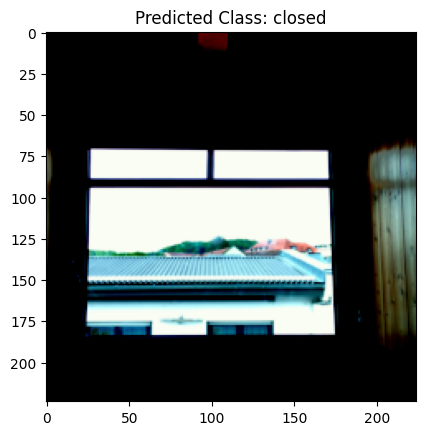

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


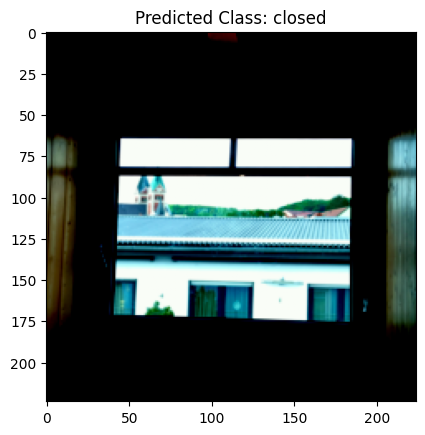

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


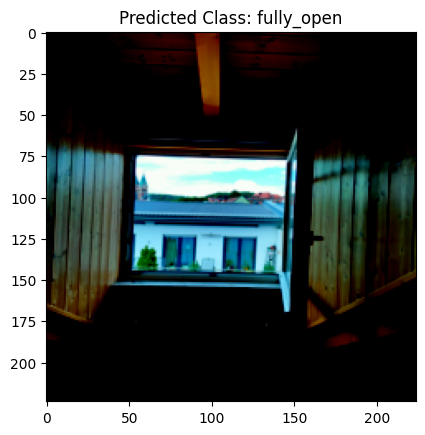

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


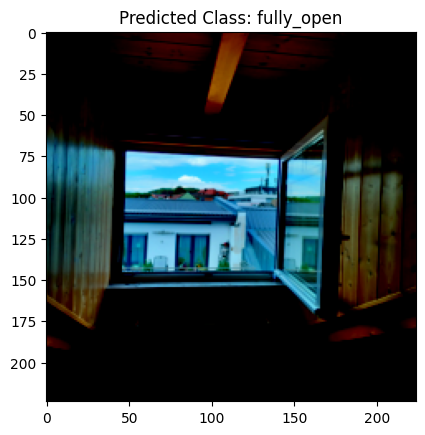

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


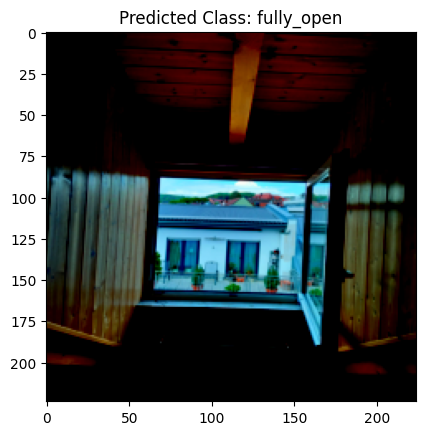

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


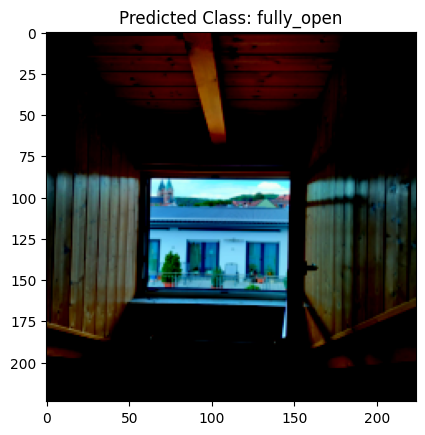

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


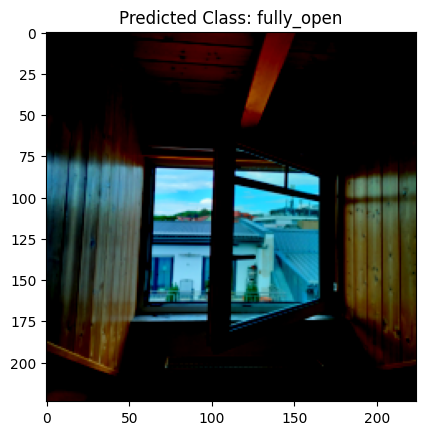

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


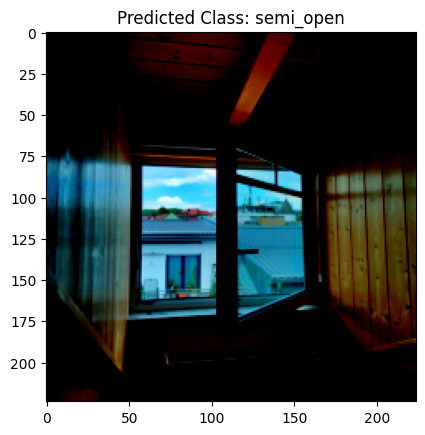

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


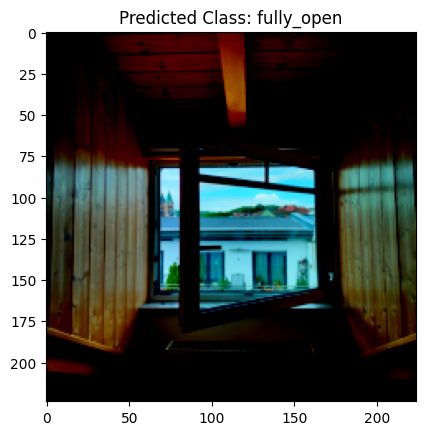

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


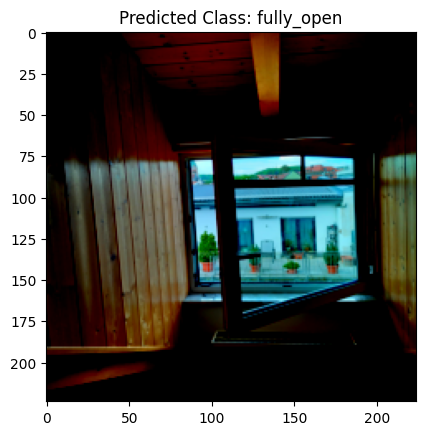

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


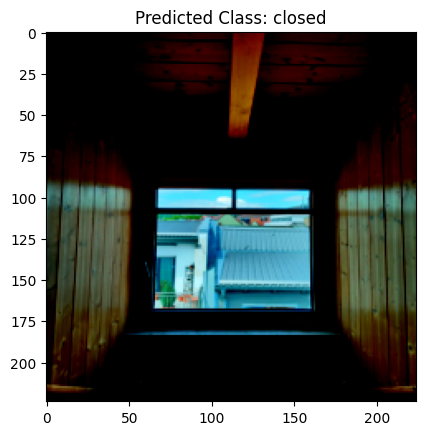

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


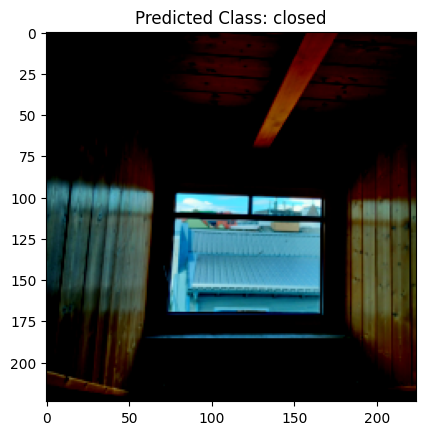

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


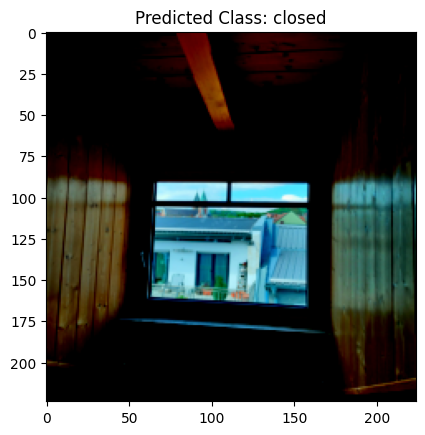

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


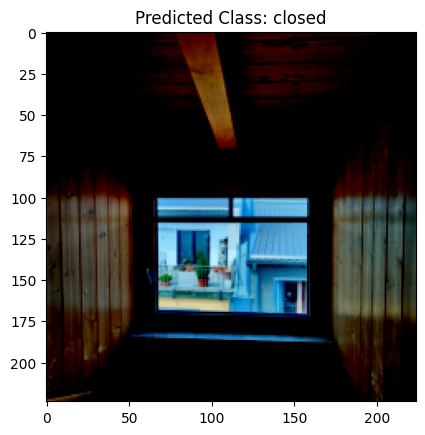

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


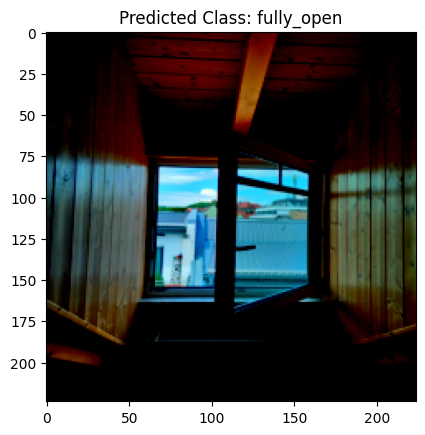

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


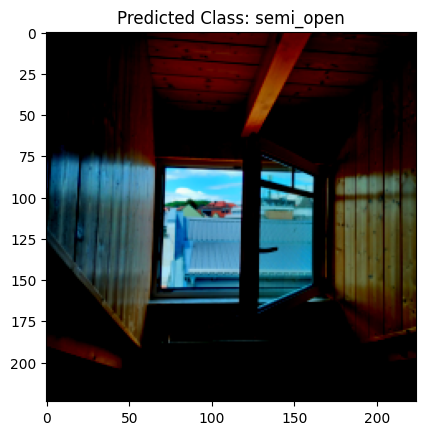

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


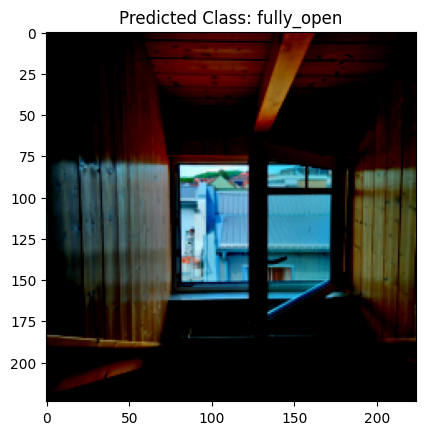

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


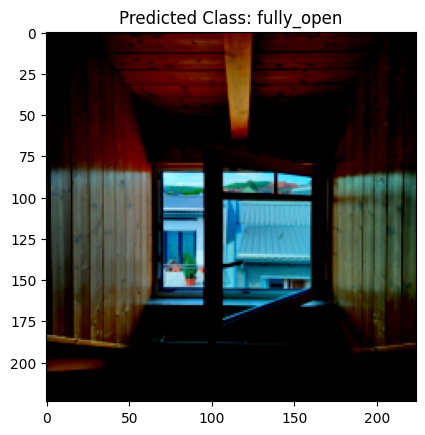

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


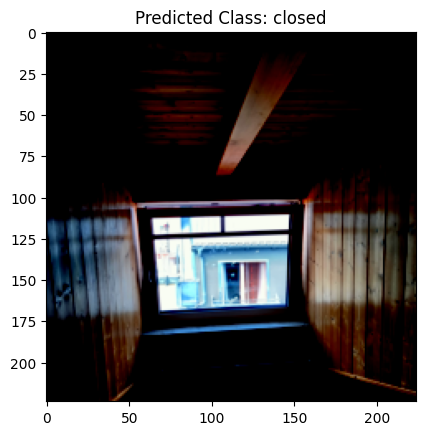

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


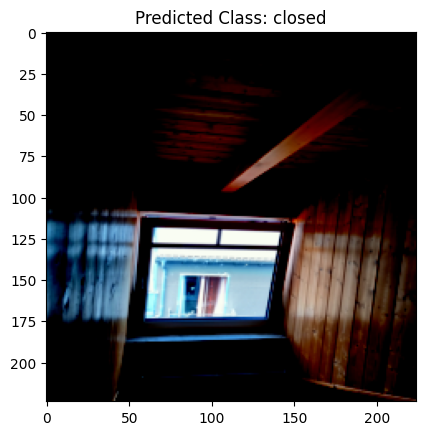

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


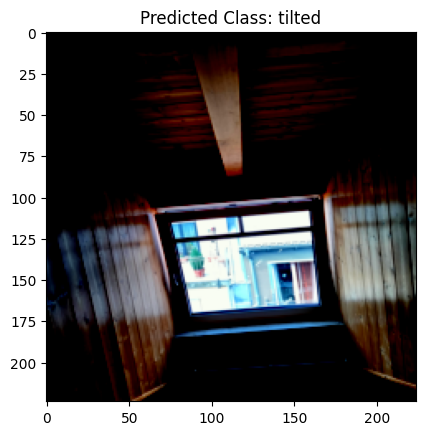

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


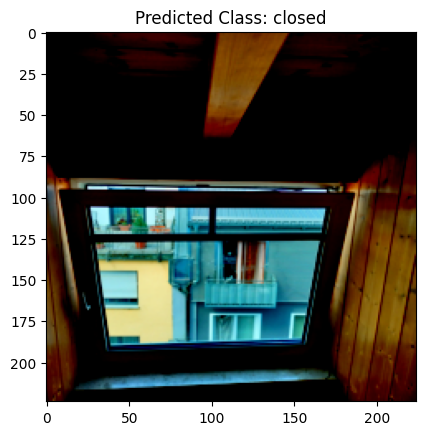

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


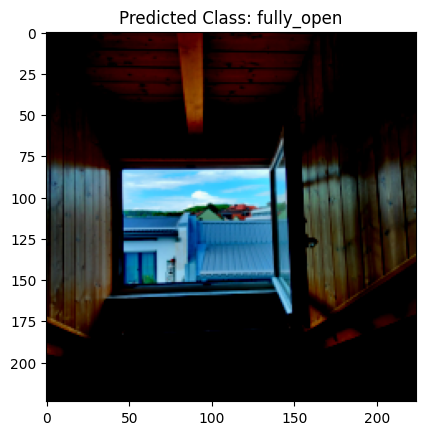

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


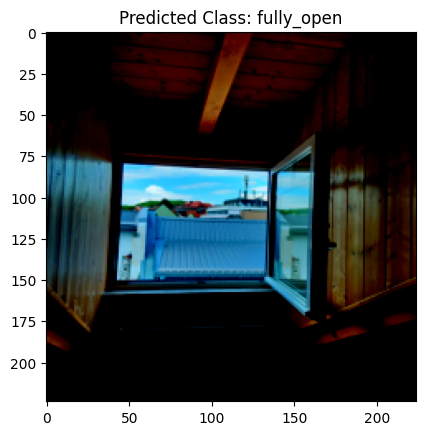

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


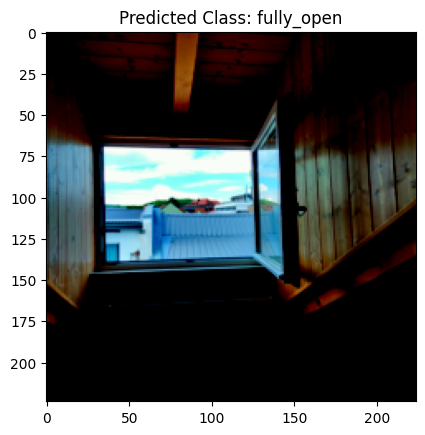

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


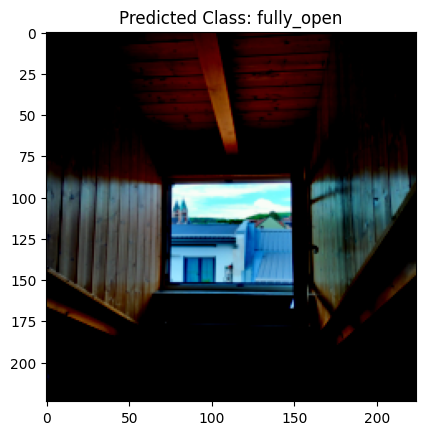

In [19]:
model_path = r"C:\Users\gokul\Desktop\CSIS_SS23\run_2_vgg.pt"


# Create an instance of the VGG model
vgg_model = models.vgg16(pretrained=True)
num_classes = len(dataset.classes)

# Modify the last fully connected layer
vgg_model.classifier[6] = nn.Linear(4096, num_classes)

# Load the saved model state dictionary
vgg_model.load_state_dict(torch.load(model_path))
vgg_model.eval()

# Define the transformation to be applied to the test images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),          # Convert the images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Load and preprocess the test images
test_folder = r'C:\Users\gokul\Desktop\CSIS_SS23\yolo_classify_dataset\test'

for img in os.listdir(test_folder):
    image_path = os.path.join(test_folder, img)
    test_image = transform(Image.open(image_path)).unsqueeze(0)
    # Make predictions on the test images
    with torch.no_grad():
        outputs = vgg_model(test_image)
        _, predicted = torch.max(outputs, 1)

    # Get the predicted class label
    predicted_class = dataset.classes[predicted.item()]

    # Convert the tensor image to a NumPy array
    image_np = np.transpose(test_image.squeeze().numpy(), (1, 2, 0))

    # Display the image and predicted class
    plt.imshow(image_np)
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()